<a href="https://colab.research.google.com/github/tanjascats/EEML-2021/blob/main/BeyondCoding_workshop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Beyond Coding Workshop: 
## L7: Privacy from a developer's perspective

### Contents:
1. Anonymisation using crowds
2. Synthetic data generation

In [ ]:
# !pip install crowds

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import json
from matplotlib import pyplot as plt
import seaborn as sns

from crowds.kanonymity.ola import anonymize
from crowds.kanonymity.information_loss import entropy_loss
from crowds.kanonymity.generalizations import GenRule

from sklearn.linear_model import LogisticRegression

In [4]:
# import data
adult = pd.read_csv('adult.csv', sep=' *; *', na_values='?', engine='python')
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30162 entries, 0 to 30161
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   sex             30162 non-null  object
 1   age             30162 non-null  int64 
 2   race            30162 non-null  object
 3   marital-status  30162 non-null  object
 4   education       30162 non-null  object
 5   native-country  30162 non-null  object
 6   workclass       30162 non-null  object
 7   occupation      30162 non-null  object
 8   salary-class    30162 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


In [5]:
# one of these two hierarchies I can write with them; and another one they try to write on their own
def generalise_marital_status(value):
  if value in ['Married-AF-spouse','Married-civ-spouse']:
    return 'spouse-present'
  elif value in ['Divorced', 'Never-married', 'Separated', 'Widowed', 'Married-spouse-absent']:
    return 'spouse-not-present'

In [6]:
def generalise_workclass(value):
  if value in ['Private', 'Self-emp-not-inc', 'Self-emp-inc']:
    return 'Non-Government'
  elif value in ['Local-gov', 'Federal-gov', 'State-gov']:
    return 'Government'
  elif value in ['Without-pay', 'Never-worked']:
    return 'Unemployed'

In [7]:
# the below generalisations will be uploaded from the json-s
def generalise_education_level1(value):
  # load dict of the first level
  # dict level_1
  with open('education_level1.json', 'rb') as infile:
    level_1 = json.load(infile)
  if value in level_1:
    return level_1[value]

In [8]:
def generalise_education_level2(value):
  with open('education_level2.json', 'rb') as infile:
    level_2 = json.load(infile)
  if value in level_2:
    return level_2[value]
  else:
    print(value)

In [9]:
def generalise_age_level1(value):
  # this is slow because it needs to open the file every time when transforming a value
  with open('age_level1.json', 'rb') as infile:
    level1 = json.load(infile)
  if str(value) in level1:
    return level1[str(value)]

In [10]:
def generalise_age_level2(value):
  with open('age_level2.json', 'rb') as infile:
    level2 = json.load(infile)
  if str(value) in level2:
    return level2[str(value)]

In [11]:
def generalise_age_level3(value):
  with open('age_level3.json', 'rb') as infile:
    level3 = json.load(infile)
  if str(value) in level3:
    return level3[str(value)]

In [12]:
def generalise_native_country(value):
  with open('native-country_level1.json', 'rb') as infile:
    level1 = json.load(infile)
  if value in level1:
    return level1[value]

In [13]:
generalization_rules = {
    'sex': GenRule([]), # 1 level
    'age': GenRule([generalise_age_level1, generalise_age_level2, generalise_age_level3]), # 4-levels generalization
    'race': GenRule([]), # 1 level
    'marital-status': GenRule([generalise_marital_status]), # 2 levels
    'education': GenRule([generalise_education_level1, generalise_education_level2]), # 3 levels
    'native-country': GenRule([generalise_native_country]), # 2 levels
    'workclass': GenRule([generalise_workclass]) # 2 levels
}

adult_anonymised, transformation = anonymize(adult, generalization_rules=generalization_rules, k=7, max_sup=0.0, info_loss=entropy_loss)

In [14]:
adult_anonymised

,sex,age,race,marital-status,education,native-country,workclass,occupation,salary-class
0,None,35-39,None,spouse-not-present,None,None,None,Adm-clerical,<=50K
1,None,35-39,None,spouse-not-present,None,None,None,Handlers-cleaners,<=50K
2,None,35-39,None,spouse-not-present,None,None,None,Exec-managerial,<=50K
3,None,35-39,None,spouse-not-present,None,None,None,Craft-repair,<=50K
4,None,35-39,None,spouse-not-present,None,None,None,Machine-op-inspct,<=50K
...,...,...,...,...,...,...,...,...,...
30157,None,80-84,None,spouse-not-present,None,None,None,Sales,<=50K
30158,None,80-84,None,spouse-not-present,None,None,None,Sales,<=50K
30159,None,80-84,None,spouse-not-present,None,None,None,Sales,>50K
30160,None,80-84,None,spouse-not-present,None,None,None,Prof-specialty,<=50K


In [15]:
transformation

{'age': 1,
 'education': 3,
 'marital-status': 1,
 'native-country': 2,
 'race': 1,
 'sex': 1,
 'workclass': 2}

Anonymisation in ARX yields the same transformation. -> ARX demo

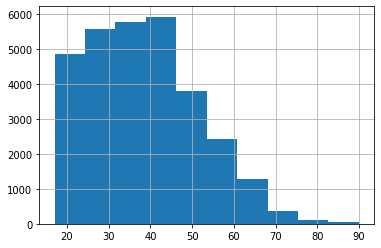

In [16]:
# utility loss via Machine Learning process
# baseline
adult.age.hist()

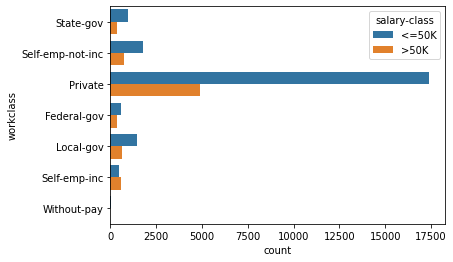

In [17]:
sns.countplot(y='workclass', hue='salary-class', data=adult)

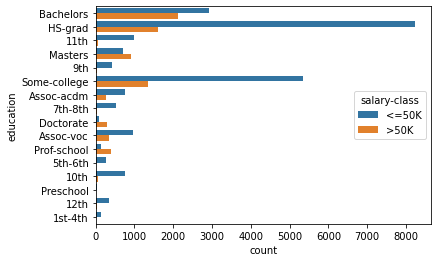

In [18]:
sns.countplot(y='education', hue='salary-class', data=adult)

In [19]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnsSelector(BaseEstimator, TransformerMixin):
  
  def __init__(self, type):
    self.type = type
  
  def fit(self, X, y=None):
    return self
  
  def transform(self,X):
    return X.select_dtypes(include=[self.type])

num_pipeline = Pipeline(steps=[("num_selector", ColumnsSelector(type='int')),
                               ('scaler', StandardScaler())])
cat_pipeline = Pipeline(steps=[("cat_selector", ColumnsSelector(type='object')),
                               ('onehot_encoder', OneHotEncoder())])

preprocessing_pipeline = FeatureUnion([('numerical_pipeline', num_pipeline),
                                       ('categorical_pipeline', cat_pipeline)])

In [20]:
X = adult.drop('salary-class', axis=1)
y = adult['salary-class']

In [21]:
X_processed = preprocessing_pipeline.fit_transform(X)

In [22]:
from sklearn.model_selection import cross_val_score

cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_processed, y, cv=5)

In [23]:
scores

array([0.82280789, 0.82413393, 0.82940981, 0.83355438, 0.82708886])

In [24]:
# ANONYMISED DATA

In [25]:
X_anon = adult_anonymised.drop('salary-class', axis=1)
y_anon = adult_anonymised['salary-class']

In [26]:
X_anon.dropna(axis=1, inplace=True)

In [27]:
X_anon

,age,marital-status,occupation
0,35-39,spouse-not-present,Adm-clerical
1,35-39,spouse-not-present,Handlers-cleaners
2,35-39,spouse-not-present,Exec-managerial
3,35-39,spouse-not-present,Craft-repair
4,35-39,spouse-not-present,Machine-op-inspct
...,...,...,...
30157,80-84,spouse-not-present,Sales
30158,80-84,spouse-not-present,Sales
30159,80-84,spouse-not-present,Sales
30160,80-84,spouse-not-present,Prof-specialty


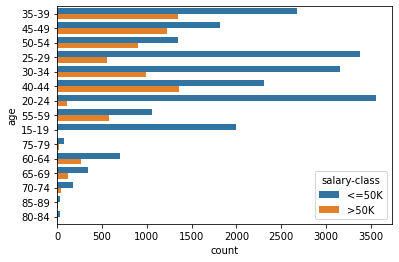

In [28]:
sns.countplot(y='age', hue='salary-class', data=adult_anonymised)

In [29]:
X_anon_processed = cat_pipeline.fit_transform(X_anon)

In [30]:
cross_val_model = LogisticRegression(random_state=0)
scores = cross_val_score(cross_val_model, X_anon_processed, y, cv=5)

In [31]:
scores 

array([0.75103597, 0.75103597, 0.75116048, 0.75116048, 0.75099469])